In [ ]:
!pip install ccxt

In [5]:
import ccxt
import pandas as pd
import datetime
import numpy as np

In [29]:
def identify_reversal_points(df):
    """
    Идентификация точек разворота тренда.
    
    Параметры:
    df - DataFrame с колонками: Date, Open Price, High Price, Low Price, Close Price, Volume.
    
    Возвращает:
    DataFrame с добавленной колонкой "Reversal", указывающей точки разворота.
    """
    # Локальный максимум — High больше, чем на предыдущем и следующем дне
    df['Reversal'] = np.where(
        (df['High Price'] > df['High Price'].shift(1)) & (df['High Price'] > df['High Price'].shift(-1)) |
        (df['Low Price'] < df['Low Price'].shift(1)) & (df['Low Price'] < df['Low Price'].shift(-1)),
        True, False
    )
    
    df['Reversal Type'] = np.select(
    [
        (df['High Price'] > df['High Price'].shift(1)) & (df['High Price'] > df['High Price'].shift(-1)),
        (df['Low Price'] < df['Low Price'].shift(1)) & (df['Low Price'] < df['Low Price'].shift(-1))
    ],
    ['Peak', 'Bottom'],
    default='default')
    return df

def fetch_binance_data(symbol, start_date):
    exchange = ccxt.binance()
    if exchange.has['fetchOHLCV']:
        since = exchange.parse8601(start_date)
        all_orders = []
        limit = 1000  # Maximum allowed value on Binance
        while since < exchange.milliseconds():
            ohlcv = exchange.fetch_ohlcv(symbol=symbol, since=since, timeframe='1d', limit=limit)
            if len(ohlcv) > 0:
                since = ohlcv[-1][0] + 1
                all_orders += ohlcv
            else:
                break
        return all_orders
    else:
        return None

def clean_data(ohlcv_list):
    temp = []
    for i in ohlcv_list:
        timestamp_with_ms = i[0]
        dt = datetime.datetime.fromtimestamp(timestamp_with_ms / 1000)
        i[0] = dt
        temp.append(i)
    return temp

def get_ohlcv_df(symbol, start_date):
    data = fetch_binance_data(symbol, start_date)
    if data is not None:
        cleaned_data = clean_data(data)
        ohlcv_df = pd.DataFrame(cleaned_data, columns=["Date", "Open Price", "High Price", "Low Price", "Close Price", "Volume"])
        return ohlcv_df
    else:
        return None

def calculate_moving_averages(df, short_window=10, long_window=50):
    df['Short Moving Average'] = df['Open Price'].rolling(window=short_window).mean()
    df['Long Moving Average'] = df['Open Price'].rolling(window=long_window).mean()
    return df

def add_signals(df):
    df['Signal'] = 0
    df.loc[df['Short Moving Average'] > df['Long Moving Average'], 'Signal'] = 1  # Bullish signal
    df.loc[df['Short Moving Average'] < df['Long Moving Average'], 'Signal'] = -1  # Bearish signal
    return df

def add_target(df):
    df['Target'] = df['Open Price'].shift(-1)
    return df

def identify_candlestick_patterns(df):
    df['Hammer'] = ((df['High Price'] - df['Close Price']) <= 2 * (df['Close Price'] - df['Low Price'])) & \
                   ((df['Close Price'] - df['Low Price']) > 2 * (df['High Price'] - df['Close Price'])) & \
                   (df['Open Price'] - df['Low Price'] < 0.1 * (df['High Price'] - df['Low Price']))

    df['Engulfing'] = (df['Close Price'] > df['Open Price']) & \
                      (df['Open Price'] < df['Close Price'].shift(1)) & \
                      (df['Close Price'] > df['Open Price'].shift(1))

    df['Gravestone'] = ((df['Close Price'] - df['Low Price']) <= 0.1 * (df['High Price'] - df['Low Price'])) & \
                       ((df['Open Price'] - df['Low Price']) <= 0.1 * (df['High Price'] - df['Low Price']))

    df['Doji'] = (abs(df['Open Price'] - df['Close Price']) <= 0.1 * (df['High Price'] - df['Low Price']))
    return df

def prepare_data_for_model(df):
    df = df.dropna()  # Drop rows with NaN
    features = ['Short Moving Average', 'Long Moving Average', 'Signal']  # Features
    X = df[features]
    y = df['Target']  # Target variable
    return X, y

def calculate_rsi(data, window=14):
    """
     Рассчитывает индикатор RSI (Relative Strength Index).

    Формула:
    RSI = 100 - (100 / (1 + RS))
    где RS = (Средний прирост за n периодов) / (Средний убыток за n периодов)
    
    Параметры:
    - data: DataFrame с колонкой 'Close'.
    - window: Окно для скользящего среднего (по умолчанию 14).
    
    Возвращает:
    - DataFrame с добавленной колонкой 'RSI'.
    """
    delta = data['Close Price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

In [42]:


symbol = "BTC/USDT"
start_date = datetime.date(2023, 12, 8)
start_date_str = start_date.strftime('%Y-%m-%dT00:00:00Z')
df = get_ohlcv_df(symbol, start_date_str)
df

,Date,Open Price,High Price,Low Price,Close Price,Volume
0,2023-12-08 03:00:00,43273.15,44700.00,43081.10,44170.99,42900.375560
1,2023-12-09 03:00:00,44171.00,44358.02,43584.51,43713.60,24925.970080
2,2023-12-10 03:00:00,43713.59,44049.00,43563.00,43789.51,18956.617580
3,2023-12-11 03:00:00,43789.50,43804.50,40222.00,41253.40,76663.898040
4,2023-12-12 03:00:00,41253.41,42104.12,40680.00,41492.39,42722.697730
...,...,...,...,...,...,...
362,2024-12-04 03:00:00,95849.69,99000.00,94587.83,98587.32,43850.537280
363,2024-12-05 03:00:00,98587.32,104088.00,90500.00,96945.63,109921.729662
364,2024-12-06 03:00:00,96945.63,101898.99,95981.72,99740.84,45049.533100
365,2024-12-07 03:00:00,99740.84,100439.18,98844.00,99831.99,14931.945900


In [43]:
df_with_MA = calculate_moving_averages(df, short_window=1, long_window=7)
df_with_signals = add_signals(df_with_MA)
df_with_signals

,Date,Open Price,High Price,Low Price,Close Price,Volume,Short Moving Average,Long Moving Average,Signal
0,2023-12-08 03:00:00,43273.15,44700.00,43081.10,44170.99,42900.375560,43273.15,NaN,0
1,2023-12-09 03:00:00,44171.00,44358.02,43584.51,43713.60,24925.970080,44171.00,NaN,0
2,2023-12-10 03:00:00,43713.59,44049.00,43563.00,43789.51,18956.617580,43713.59,NaN,0
3,2023-12-11 03:00:00,43789.50,43804.50,40222.00,41253.40,76663.898040,43789.50,NaN,0
4,2023-12-12 03:00:00,41253.41,42104.12,40680.00,41492.39,42722.697730,41253.41,NaN,0
...,...,...,...,...,...,...,...,...,...
362,2024-12-04 03:00:00,95849.69,99000.00,94587.83,98587.32,43850.537280,95849.69,96321.508571,-1
363,2024-12-05 03:00:00,98587.32,104088.00,90500.00,96945.63,109921.729662,98587.32,96710.681429,1
364,2024-12-06 03:00:00,96945.63,101898.99,95981.72,99740.84,45049.533100,96945.63,96896.630000,1
365,2024-12-07 03:00:00,99740.84,100439.18,98844.00,99831.99,14931.945900,99740.84,97222.464286,1


In [44]:
df_with_patterns = identify_candlestick_patterns(df_with_signals)
df_with_RSI = calculate_rsi(df_with_patterns)

In [45]:
df_with_rev = identify_reversal_points(df_with_RSI)
df_with_rev

,Date,Open Price,High Price,Low Price,Close Price,Volume,Short Moving Average,Long Moving Average,Signal,Hammer,Engulfing,Gravestone,Doji,RSI,Reversal,Reversal Type
0,2023-12-08 03:00:00,43273.15,44700.00,43081.10,44170.99,42900.375560,43273.15,NaN,0,False,False,False,False,NaN,False,default
1,2023-12-09 03:00:00,44171.00,44358.02,43584.51,43713.60,24925.970080,44171.00,NaN,0,False,False,False,False,NaN,False,default
2,2023-12-10 03:00:00,43713.59,44049.00,43563.00,43789.51,18956.617580,43713.59,NaN,0,False,False,False,False,NaN,False,default
3,2023-12-11 03:00:00,43789.50,43804.50,40222.00,41253.40,76663.898040,43789.50,NaN,0,False,False,False,False,NaN,True,Bottom
4,2023-12-12 03:00:00,41253.41,42104.12,40680.00,41492.39,42722.697730,41253.41,NaN,0,False,False,False,False,NaN,False,default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2024-12-04 03:00:00,95849.69,99000.00,94587.83,98587.32,43850.537280,95849.69,96321.508571,-1,False,False,False,False,59.019627,False,default
363,2024-12-05 03:00:00,98587.32,104088.00,90500.00,96945.63,109921.729662,98587.32,96710.681429,1,False,False,False,False,46.803389,True,Peak
364,2024-12-06 03:00:00,96945.63,101898.99,95981.72,99740.84,45049.533100,96945.63,96896.630000,1,False,False,False,False,51.792876,False,default
365,2024-12-07 03:00:00,99740.84,100439.18,98844.00,99831.99,14931.945900,99740.84,97222.464286,1,False,False,False,True,54.789695,False,default


In [46]:
# Замена True/False на бинарные признаки (1 и 0)
bool_cols = df_with_rev.select_dtypes(include=['bool']).columns
df_with_rev[bool_cols] = df_with_rev[bool_cols].astype(int)

# Применение One-Hot-Encoding к категориальным признакам
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df_with_rev = pd.get_dummies(df_with_rev, columns=categorical_cols, drop_first=True, dtype=int)

df_with_rev

,Date,Open Price,High Price,Low Price,Close Price,Volume,Short Moving Average,Long Moving Average,Signal,Hammer,Engulfing,Gravestone,Doji,RSI,Reversal,Reversal Type_Peak,Reversal Type_default
0,2023-12-08 03:00:00,43273.15,44700.00,43081.10,44170.99,42900.375560,43273.15,NaN,0,0,0,0,0,NaN,0,0,1
1,2023-12-09 03:00:00,44171.00,44358.02,43584.51,43713.60,24925.970080,44171.00,NaN,0,0,0,0,0,NaN,0,0,1
2,2023-12-10 03:00:00,43713.59,44049.00,43563.00,43789.51,18956.617580,43713.59,NaN,0,0,0,0,0,NaN,0,0,1
3,2023-12-11 03:00:00,43789.50,43804.50,40222.00,41253.40,76663.898040,43789.50,NaN,0,0,0,0,0,NaN,1,0,0
4,2023-12-12 03:00:00,41253.41,42104.12,40680.00,41492.39,42722.697730,41253.41,NaN,0,0,0,0,0,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2024-12-04 03:00:00,95849.69,99000.00,94587.83,98587.32,43850.537280,95849.69,96321.508571,-1,0,0,0,0,59.019627,0,0,1
363,2024-12-05 03:00:00,98587.32,104088.00,90500.00,96945.63,109921.729662,98587.32,96710.681429,1,0,0,0,0,46.803389,1,1,0
364,2024-12-06 03:00:00,96945.63,101898.99,95981.72,99740.84,45049.533100,96945.63,96896.630000,1,0,0,0,0,51.792876,0,0,1
365,2024-12-07 03:00:00,99740.84,100439.18,98844.00,99831.99,14931.945900,99740.84,97222.464286,1,0,0,0,1,54.789695,0,0,1


In [47]:
prep_data = df_with_rev.drop(columns=["Short Moving Average","Long Moving Average"])
prep_data = prep_data.dropna()
prep_data

,Date,Open Price,High Price,Low Price,Close Price,Volume,Signal,Hammer,Engulfing,Gravestone,Doji,RSI,Reversal,Reversal Type_Peak,Reversal Type_default
13,2023-12-21 03:00:00,43668.92,44242.35,43286.72,43861.80,34624.293840,1,0,1,0,0,48.515239,0,0,1
14,2023-12-22 03:00:00,43861.79,44398.26,43412.54,43969.04,32783.196380,1,0,1,0,0,49.040102,1,1,0
15,2023-12-23 03:00:00,43969.04,43988.68,43291.10,43702.16,16557.129300,1,0,0,0,0,49.944621,0,0,1
16,2023-12-24 03:00:00,43702.15,43946.00,42500.00,42991.50,25144.334960,1,0,0,0,0,46.360636,1,0,0
17,2023-12-25 03:00:00,42991.50,43802.32,42720.43,43576.13,27021.239920,-1,0,0,0,0,62.886716,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2024-12-04 03:00:00,95849.69,99000.00,94587.83,98587.32,43850.537280,-1,0,0,0,0,59.019627,0,0,1
363,2024-12-05 03:00:00,98587.32,104088.00,90500.00,96945.63,109921.729662,1,0,0,0,0,46.803389,1,1,0
364,2024-12-06 03:00:00,96945.63,101898.99,95981.72,99740.84,45049.533100,1,0,0,0,0,51.792876,0,0,1
365,2024-12-07 03:00:00,99740.84,100439.18,98844.00,99831.99,14931.945900,1,0,0,0,1,54.789695,0,0,1


In [48]:
prep_data.to_csv("data.csv", index=False)


In [49]:
prep_data.columns

Index(['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price',
       'Volume', 'Signal', 'Hammer', 'Engulfing', 'Gravestone', 'Doji', 'RSI',
       'Reversal', 'Reversal Type_Peak', 'Reversal Type_default'],
      dtype='object')

In [51]:
prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 13 to 366
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   354 non-null    datetime64[ns]
 1   Open Price             354 non-null    float64       
 2   High Price             354 non-null    float64       
 3   Low Price              354 non-null    float64       
 4   Close Price            354 non-null    float64       
 5   Volume                 354 non-null    float64       
 6   Signal                 354 non-null    int64         
 7   Hammer                 354 non-null    int32         
 8   Engulfing              354 non-null    int32         
 9   Gravestone             354 non-null    int32         
 10  Doji                   354 non-null    int32         
 11  RSI                    354 non-null    float64       
 12  Reversal               354 non-null    int32         
 13  Reversal 

In [53]:
!pip install statsmodels pykalman

You should consider upgrading via the 'C:\Users\china\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [54]:
from statsmodels.tsa.arima.model import ARIMA
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

ARIMA MAE: 1430.219259964894
ARIMA RMSE: 2081.000051142034


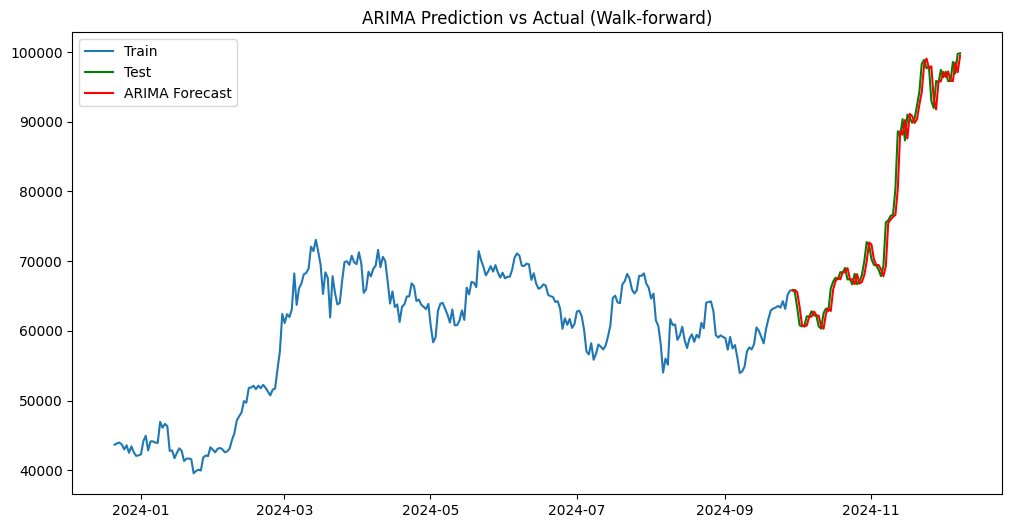

ARIMA+KF MAE: 609.0792748122648
ARIMA+KF RMSE: 846.5116539834222


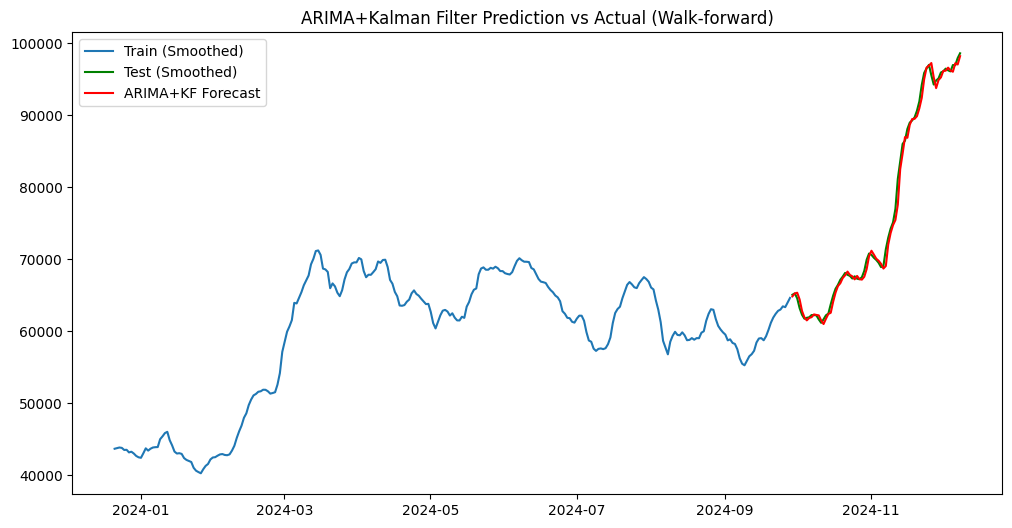

In [ ]:
df = prep_data.copy()
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

# Выделим временной ряд Open Price
ts = df['Open Price']

# ---------------------------------
# Предсказание с применением ARIMA (walk-forward validation)
# ---------------------------------
# Разбиение на 80/20
train_size = int(len(ts) * 0.8)
train_data = ts.iloc[:train_size]
test_data = ts.iloc[train_size:]

# Настройка параметров ARIMA
p, d, q = 5, 1, 0

# Walk-forward validation
history = list(train_data)
predictions = []

for t in range(len(test_data)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    predictions.append(forecast[0])
    history.append(test_data.iloc[t])

# Оценим качество предсказаний
predictions = np.array(predictions)
mae = np.mean(np.abs(predictions - test_data.values))
rmse = np.sqrt(np.mean((predictions - test_data.values) ** 2))
print("ARIMA MAE:", mae)
print("ARIMA RMSE:", rmse)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test', color='green')
plt.plot(test_data.index, predictions, label='ARIMA Forecast', color='red')
plt.title('ARIMA Prediction vs Actual (Walk-forward)')
plt.legend()
plt.show()

# ---------------------------------
# (Опционально) Предсказание с применением фильтра Калмана
# ---------------------------------
# Настройка фильтра. Допустим простейший вариант с 1D наблюдениями.
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=ts.iloc[0],
    initial_state_covariance=1,
    observation_covariance=0.5,  
    transition_covariance=0.1   
)

state_means, state_covs = kf.filter(ts.values)
smoothed_ts = state_means.flatten()

# Преобразуем сглаженный ряд в Series с тем же индексом
smoothed_series = pd.Series(smoothed_ts, index=ts.index)

# Разбиение на 80/20
train_data_smoothed = smoothed_series.iloc[:train_size]
test_data_smoothed = smoothed_series.iloc[train_size:]

# Walk-forward validation с фильтром Калмана
history_smoothed = list(train_data_smoothed)
predictions_smoothed = []

for t in range(len(test_data_smoothed)):
    model_kf = ARIMA(history_smoothed, order=(p, d, q))
    model_kf_fit = model_kf.fit()
    forecast_kf = model_kf_fit.forecast(steps=1)
    predictions_smoothed.append(forecast_kf[0])
    history_smoothed.append(test_data_smoothed.iloc[t])

# Оценим качество предсказаний
predictions_smoothed = np.array(predictions_smoothed)
mae_kf = np.mean(np.abs(predictions_smoothed - test_data_smoothed.values))
rmse_kf = np.sqrt(np.mean((predictions_smoothed - test_data_smoothed.values) ** 2))
print("ARIMA+KF MAE:", mae_kf)
print("ARIMA+KF RMSE:", rmse_kf)

# Визуализация результатов с фильтром Калмана
plt.figure(figsize=(12, 6))
plt.plot(train_data_smoothed.index, train_data_smoothed, label='Train (Smoothed)')
plt.plot(test_data_smoothed.index, test_data_smoothed, label='Test (Smoothed)', color='green')
plt.plot(test_data_smoothed.index, predictions_smoothed, label='ARIMA+KF Forecast', color='red')
plt.title('ARIMA+Kalman Filter Prediction vs Actual (Walk-forward)')
plt.legend()
plt.show()

In [64]:
def predict_arima_kf(date):
    if date not in test_data_smoothed.index:
        return f"Дата {date} не найдена в тестовой выборке."
    
    # Подготовка истории для обучения
    history_smoothed = list(train_data_smoothed[:date])
    model_kf = ARIMA(history_smoothed, order=(5, 1, 0))
    model_kf_fit = model_kf.fit()
    forecast_kf = model_kf_fit.forecast(steps=1)
    
    # Получение реального значения
    actual_value_smoothed = test_data_smoothed.loc[date]
    predicted_value_smoothed = forecast_kf[0]
    
    return {
        "date": date,
        "predicted_value": predicted_value_smoothed,
        "actual_value": actual_value_smoothed
    }


def predict_arima(date):
    if date not in test_data.index:
        return f"Дата {date} не найдена в тестовой выборке."
    
    # Подготовка истории для обучения
    history = list(train_data[:date])
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    
    # Получение реального значения
    actual_value = test_data.loc[date]
    predicted_value = forecast[0]
    
    return {
        "date": date,
        "predicted_value": predicted_value,
        "actual_value": actual_value
    }

date_to_predict = test_data.index[0]  

# Прогноз ARIMA
arima_result = predict_arima(date_to_predict)
print("ARIMA Result:", arima_result)

# Прогноз ARIMA+KF
arima_kf_result = predict_arima_kf(date_to_predict)
print("ARIMA+KF Result:", arima_kf_result)

ARIMA Result: {'date': Timestamp('2024-09-29 03:00:00'), 'predicted_value': 65801.15690886334, 'actual_value': 65858.0}
ARIMA+KF Result: {'date': Timestamp('2024-09-29 03:00:00'), 'predicted_value': 64851.30065650525, 'actual_value': 65074.352517107596}
